# Обучающая выборка 
Обучающая выборка содержит информацию о просмотрах фильмов около 200 000+ пользователей за 70 дней. Участникам потребуется предсказать ТОП-20 наиболее релевантных фильмов каждому из пользователей, просмотренных им в следующие 30 дней.

movies.сsv - файл с данными фильмов:
- id - id фильма,
- name - название,
- year - год выпуска,
- date_publication - дата публикации,
- genres - список id жанров,
- countries - список id стран производства,
- description - описание фильма,
- staff - список id staff.

genres.csv - файл с данными жанров:
- id - id жанра,
- name - имя жанра.

countries.csv - файл с данными стран:
- id - id страны,
- name - имя страны.

staff.csv - файл с данными сочетания персона и должность:
- id - id записи,
- name - имя персоны,
- role - актер/режиссёр/ и т.д.

logs.csv - файл с данными логов событий о просмотрах фильмов:
- id - id записи,
- datetime - время события (окончание просмотра фильма),
- user_id - id пользователя,
- movie_id - id фильма,
- duration - длительность просмотра фильма.


# Задание:
Разработать рекомендательную систему, обучить ее на предоставленных данных и предсказать ТОП-20 фильмов, которые каждый пользователь из Обучающей выборки посмотрит в будущем. Проверка осуществляется сравнением предсказания модели с фактическими просмотрами пользователей.

# LIBs & data

In [147]:
import re

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.style.use('ggplot')

sns.set_theme(style='whitegrid')
sns.set_theme(rc={'figure.figsize':(17, 9)})
sns.set_context("paper", rc={"font.size":18,"axes.titlesize":25,"axes.labelsize":18,
                            "xtick.labelsize": 14, "ytick.labelsize": 14})
colors = sns.color_palette("hls")

In [291]:
countries_df = pd.read_csv('data/train/countries.csv')
genres_df = pd.read_csv('data/train/genres.csv')
logs_df =  pd.read_csv('data/train/logs.csv')
movies_df = pd.read_csv('data/train/movies.csv')
staff_df = pd.read_csv('data/train/staff.csv')

# очистка данных

In [149]:
def print_inspect(df):
    columns = df.columns
    print('признаки:\n{}'.format(df.columns))
    print('-'*80)
    for column in columns:
        print(f'Количество уникальных значений в столбце {column}: {df[column].nunique()}')
    print('-'*80)
    print('Количество пропусков:\n{}'.format(df.isna().sum()))
    print('-'*80)
    print(df.info())

In [150]:
print_inspect(countries_df)

признаки:
Index(['id', 'name'], dtype='object')
--------------------------------------------------------------------------------
Количество уникальных значений в столбце id: 100
Количество уникальных значений в столбце name: 100
--------------------------------------------------------------------------------
Количество пропусков:
id      0
name    0
dtype: int64
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      100 non-null    int64 
 1   name    100 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.7+ KB
None


In [151]:
print_inspect(genres_df)

признаки:
Index(['id', 'name'], dtype='object')
--------------------------------------------------------------------------------
Количество уникальных значений в столбце id: 96
Количество уникальных значений в столбце name: 96
--------------------------------------------------------------------------------
Количество пропусков:
id      0
name    0
dtype: int64
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      96 non-null     int64 
 1   name    96 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
None


In [152]:
print_inspect(staff_df)
print('-'*80)
print('Количество дубликатов:\n{}'.format(staff_df[staff_df.duplicated(subset=['name','role']) | staff_df.duplicated(subset=['name','id'])].shape[0]))

признаки:
Index(['id', 'name', 'role'], dtype='object')
--------------------------------------------------------------------------------
Количество уникальных значений в столбце id: 35684
Количество уникальных значений в столбце name: 33068
Количество уникальных значений в столбце role: 8
--------------------------------------------------------------------------------
Количество пропусков:
id      0
name    0
role    0
dtype: int64
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35684 entries, 0 to 35683
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      35684 non-null  int64 
 1   name    35684 non-null  object
 2   role    35684 non-null  object
dtypes: int64(1), object(2)
memory usage: 836.5+ KB
None
--------------------------------------------------------------------------------
Количество дубликатов:
0


In [153]:
print_inspect(logs_df)
print('-'*80)
print('Количество дубликатов:\n{}'.format(logs_df.duplicated().sum()))

признаки:
Index(['id', 'datetime', 'user_id', 'movie_id', 'duration'], dtype='object')
--------------------------------------------------------------------------------
Количество уникальных значений в столбце id: 2477905
Количество уникальных значений в столбце datetime: 2477904
Количество уникальных значений в столбце user_id: 207377
Количество уникальных значений в столбце movie_id: 5283
Количество уникальных значений в столбце duration: 14374
--------------------------------------------------------------------------------
Количество пропусков:
id          0
datetime    0
user_id     0
movie_id    0
duration    0
dtype: int64
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2477905 entries, 0 to 2477904
Data columns (total 5 columns):
 #   Column    Dtype  
---  ------    -----  
 0   id        int64  
 1   datetime  object 
 2   user_id   int64  
 3   movie_id  float64
 4   duration  float64
dtypes: fl

In [154]:
print_inspect(movies_df)
print('-'*80)
print('Количество дубликатов:\n{}'.format(movies_df.duplicated(subset=['description','name']).sum()))

признаки:
Index(['id', 'name', 'year', 'date_publication', 'description', 'genres',
       'countries', 'staff'],
      dtype='object')
--------------------------------------------------------------------------------
Количество уникальных значений в столбце id: 7427
Количество уникальных значений в столбце name: 7223
Количество уникальных значений в столбце year: 99
Количество уникальных значений в столбце date_publication: 576
Количество уникальных значений в столбце description: 6822
Количество уникальных значений в столбце genres: 862
Количество уникальных значений в столбце countries: 586
Количество уникальных значений в столбце staff: 6258
--------------------------------------------------------------------------------
Количество пропусков:
id                     0
name                   0
year                   0
date_publication    2504
description          139
genres                 0
countries              0
staff                  0
dtype: int64
-------------------------------

In [155]:
grouped_duplicates = movies_df[movies_df.duplicated(subset=['description','name'])]
movies_df[movies_df['name'].isin(grouped_duplicates['name'])].sort_values(by='name')

,id,name,year,date_publication,description,genres,countries,staff
1012,1012,Большие глаза,2015-01-01,2023-06-21T00:00:00,«Золотой глобус» в номинации «Лучшая женская р...,"[138, 97]",[121],"[17275, 28847, 4746, 33992, 33809, 23337, 7507..."
2252,2252,Большие глаза,2014-01-01,NaN,«Золотой глобус» в номинации «Лучшая женская р...,"[138, 97]","[121, 102]","[11954, 28847, 4746, 33527, 33809, 23337, 8488..."
2445,2445,Лесная царевна,2005-01-01,NaN,"Известная русская сказка, в которой младший из...",[130],[238],"[28371, 24157, 23704, 1579, 7533, 16975, 29993..."
2706,2706,Лесная царевна,2004-01-01,NaN,"Известная русская сказка, в которой младший из...","[130, 2]",[238],"[28371, 24157, 1579, 7533, 16975, 33679, 23704..."
4822,4822,Мания Жизели,1996-01-01,NaN,История великой русской балерины Ольги Спесивц...,[97],[238],"[25228, 7536, 16089, 11698, 13160, 22452]"
7027,7027,Мания Жизели,1995-01-01,NaN,История великой русской балерины Ольги Спесивц...,[97],[238],"[6569, 13165, 29113, 8815, 8437, 27036, 7298, ..."
2625,2625,Ночной портье,2021-01-01,NaN,Из-за синдрома Аспергера Барт Бромли с трудом ...,"[97, 303]",[102],"[5628, 34880, 6698, 7163, 11476, 21983, 22799]"
6494,6494,Ночной портье,2020-01-01,2022-11-23T00:00:00,Из-за синдрома Аспергера Барт Бромли с трудом ...,"[97, 303]",[],"[5628, 34880, 6698, 7163, 11476, 21983, 22799]"
535,535,Последний день Земли,2021-01-01,2023-04-12T00:00:00,Недалекое будущее. Единственный источник энерг...,"[97, 158, 266]",[0],"[3278, 25659, 23811, 31869, 16052, 14101, 6486..."
5014,5014,Последний день Земли,2020-01-01,NaN,Недалекое будущее. Единственный источник энерг...,"[97, 158, 266]",[0],"[28412, 3278, 15060, 25659, 23998, 23811, 3186..."


Дубликаты действительно являются представлением одних и тех же фильмом. Почти треть фильмов не содержит данные о дате публикации, таким образом зависимость даты выхода и даты просмотра более релевантна. Удалим дубликаты и дату публикации. Как показывает практика содержание фильма не относится к параметру значительно влияющему на качество предсказания, оставим его без изменений. Дату выхода фильма освободим от излишней инфомации.

In [156]:
movies_df = movies_df.drop_duplicates(subset=['description','name'])
movies_df = movies_df.drop('date_publication', axis=1)

movies_df['year'] = pd.to_datetime(movies_df['year']).dt.year

Создадим новые признаки на основе времени для последующего анализа

In [157]:
# создание новых признаков на основе столбца datetime
logs_df['datetime'] = pd.to_datetime(logs_df['datetime'])
logs_df['week'] = logs_df['datetime'].dt.isocalendar().week
logs_df['day_of_week'] = logs_df['datetime'].dt.dayofweek
# преобразуем movie_id к целочисленному типу
logs_df['movie_id'] = logs_df['movie_id'].astype(int)

# EDA

Посмотрим на активность пользователей в каждую неделю. В нашем случае активность пользователей распределена равномерно, исключение составляют первая и последняя неделя, что стоит учитывать при разбиении на учебную и тестовую выборки. Подавляющее большенство фильмов представленных в выборке вышли в течении последних 4-х лет.

Text(0.5, 0, 'недели')

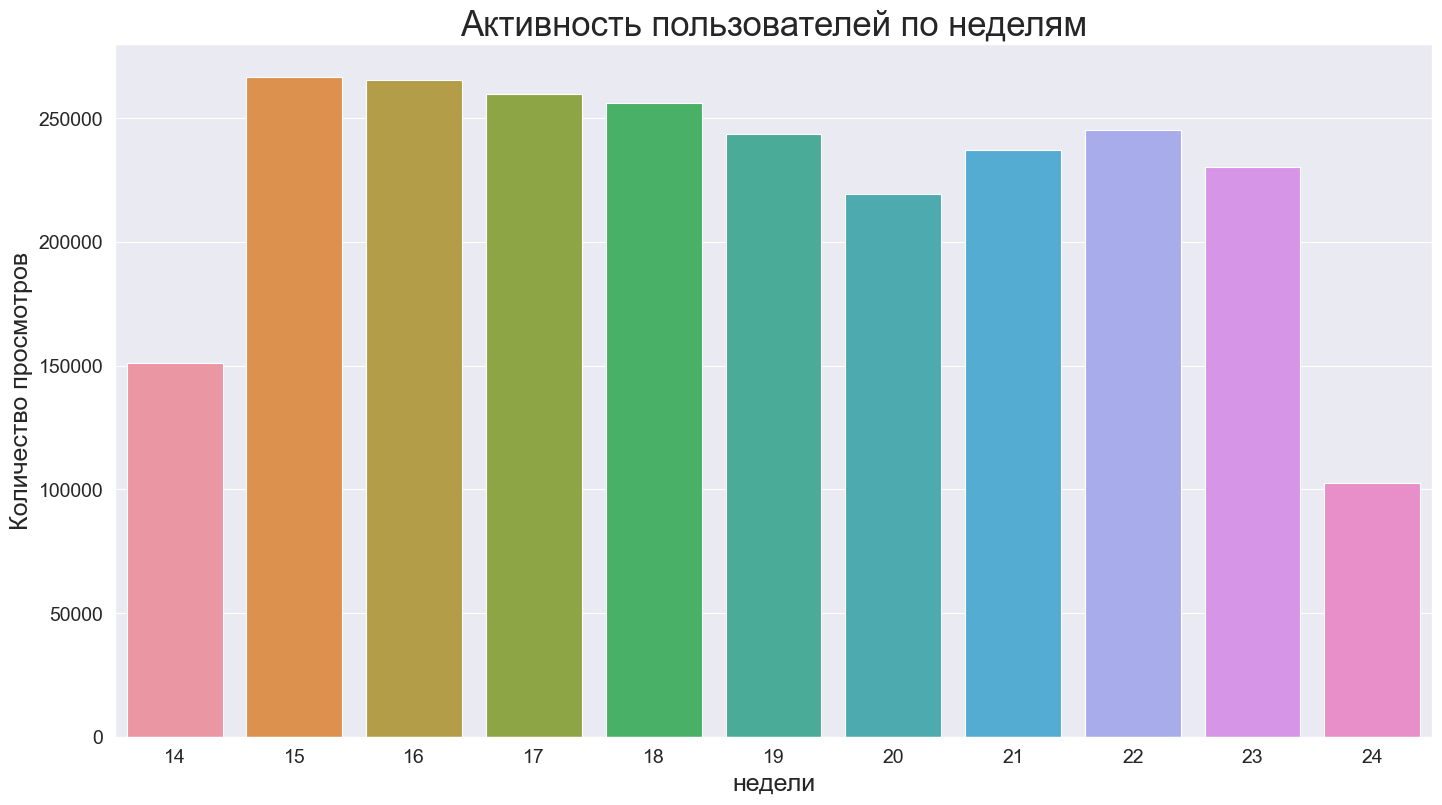

In [158]:
by_week = logs_df.sort_values(by = ['week', 'movie_id']).set_index(['week', 'movie_id'])
by_week = by_week.pivot_table(index='movie_id', columns = 'week', values = 'user_id', aggfunc = 'count', fill_value = 0)
by_week['max_by_weeks'] = by_week[by_week.columns].max(axis = 1)['max_by_weeks'] = by_week[by_week.columns].max(axis = 1)
week_progress = by_week.drop('max_by_weeks', axis = 1).sum().to_frame()
week_progress.reset_index(inplace = True)

week_progress.rename(columns = {'index': 'week', 0: 'num_watches'}, inplace = True)
sns.barplot(data = week_progress, x = 'week', y = 'num_watches')
plt.title('Активность пользователей по неделям')
plt.ylabel('Количество просмотров')
plt.xlabel('недели')

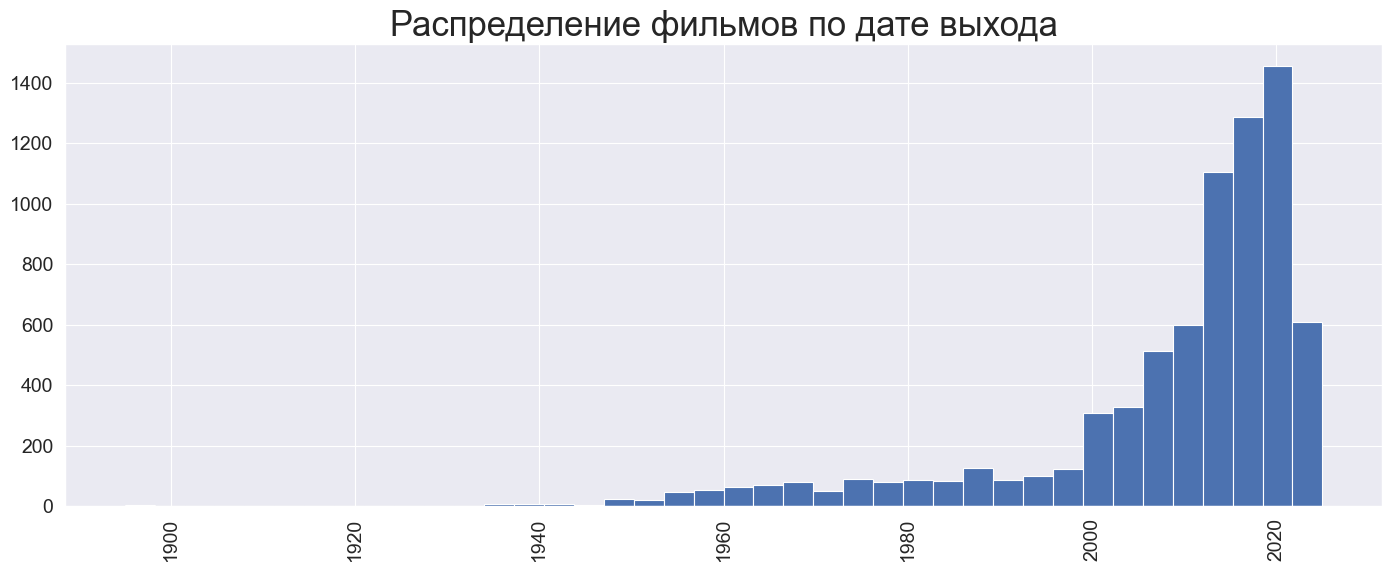

In [159]:
plt.figure(figsize = (17, 6))
movies_df.year.hist(bins=40).set_title('Распределение фильмов по дате выхода')
plt.xticks(rotation=90) 
plt.show()


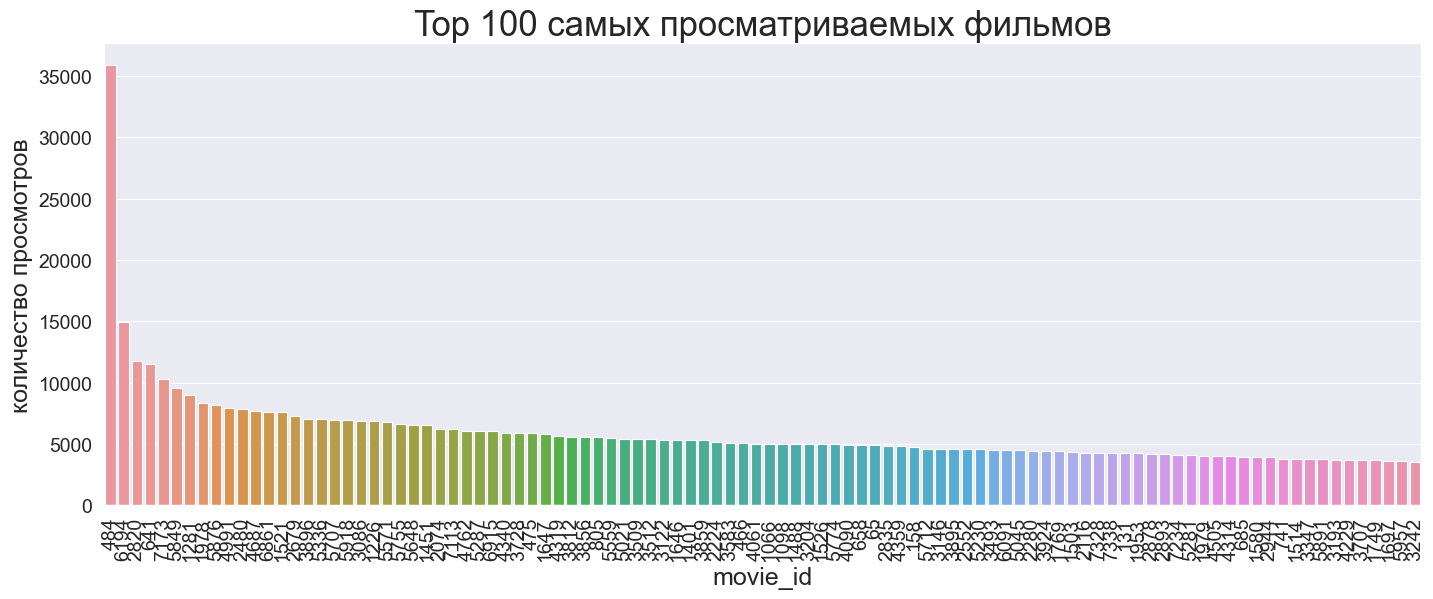

In [164]:
items_watch_count = logs_df['movie_id'].value_counts()

items_watch_cnt_df = pd.DataFrame(items_watch_count).rename(columns = {'movie_id': 'item_watch_cnt'})
items_watch_cnt_df.reset_index(inplace = True)

plt.figure(figsize = (17, 6))

bplot = sns.barplot(data = items_watch_cnt_df.head(100), x = 'index', 
            y = 'item_watch_cnt', order = items_watch_cnt_df.head(100)['index'])
bplot.set_title('Top 100 самых просматриваемых фильмов')
bplot.set_ylabel('количество просмотров')
bplot.set_xlabel('movie_id')
bplot.set_xticklabels(items_watch_cnt_df.head(100)['index'], rotation = 90);

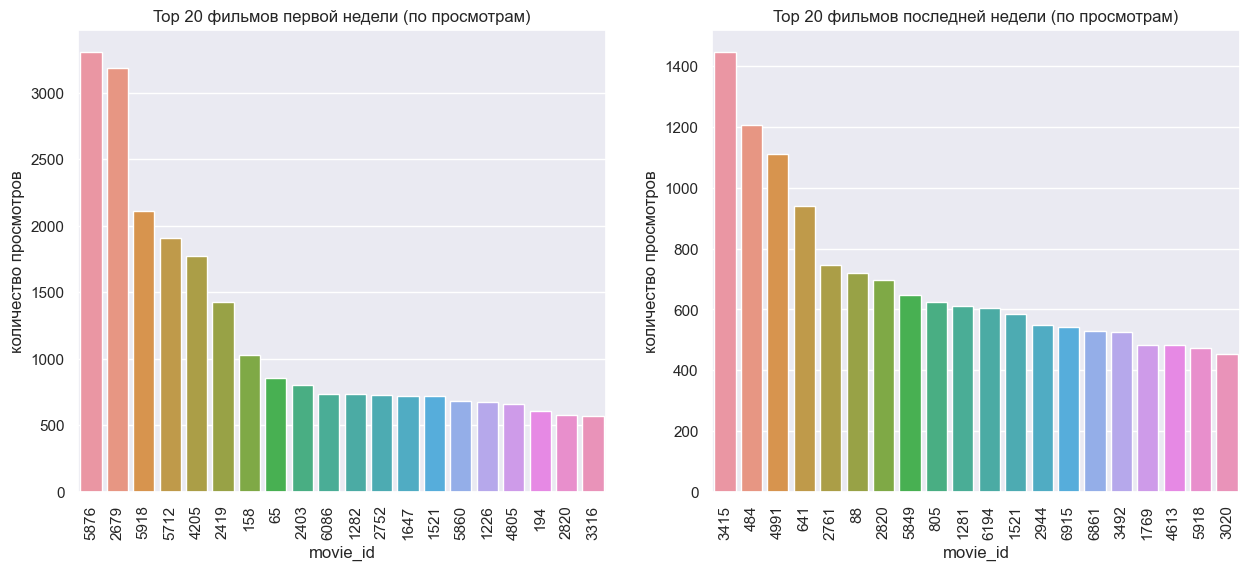

In [208]:
iwc_first_week = logs_df[logs_df['week'] == 14]

iwc_first_week = pd.DataFrame(iwc_first_week['movie_id'].value_counts()).rename(columns = {'movie_id': 'item_watch_cnt'})
iwc_first_week.reset_index(inplace = True)

iwc_last_week = logs_df[logs_df['week'] == 24]

iwc_last_week = pd.DataFrame(iwc_last_week['movie_id'].value_counts()).rename(columns = {'movie_id': 'item_watch_cnt'})
iwc_last_week.reset_index(inplace = True)


forfig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 6))
bplot = sns.barplot(data = iwc_first_week.head(20),ax = axes[0], x = 'index', 
            y = 'item_watch_cnt', order = iwc_first_week.head(20)['index'])
bplot.set_title('Top 20 фильмов первой недели (по просмотрам)')
bplot.set_ylabel('количество просмотров')
bplot.set_xlabel('movie_id')
bplot.set_xticklabels(iwc_first_week.head(20)['index'], rotation = 90);

bplot_1 = sns.barplot(data = iwc_last_week.head(20), x = 'index', 
            y = 'item_watch_cnt', order = iwc_last_week.head(20)['index'])
bplot_1.set_title('Top 20 фильмов последней недели (по просмотрам)')
bplot_1.set_ylabel('количество просмотров')
bplot_1.set_xlabel('movie_id')
bplot_1.set_xticklabels(iwc_last_week.head(20)['index'], rotation = 90);

In [284]:
top_20l = pd.DataFrame(logs_df['movie_id'].value_counts().head(20))
top_20l.reset_index(inplace=True)

top_20 = movies_df[movies_df['id'].isin(top_20l['index'].head(20))].reindex(top_20l['index'])
top_20.reset_index(inplace=True)
top_20 = top_20.drop('index',axis=1)
top_20

,id,name,year,description,genres,countries,staff
0,484,Аватар: Путь воды,2023,Джейк Салли живёт в образе аватара уже много л...,"[158, 294, 266, 302]",[102],"[15325, 23343, 18928, 23330, 5187, 30892, 1481..."
1,6194,Нюрнберг,2023,Советская делегация пытается помешать тайным а...,"[97, 303, 143, 319]","[122, 188, 238, 20]","[2590, 33845, 11031, 26970, 15345]"
2,2820,Алёша Попович и Тугарин Змей,2004,«Алеша Попович и Тугарин Змей» (2004) — семейн...,[261],[238],"[9540, 4845, 17587, 11083, 5536, 26849, 17882,..."
3,641,Семейный бизнес,2021,Герою предстоит сложный моральный выбор – помо...,[218],[102],"[5486, 22716, 19731, 13417, 11081, 31195, 2720..."
4,7173,Соник 2 в кино,2022,Соника ждут новые приключения! Профессор Эггма...,"[46, 294, 266]","[102, 166]","[8200, 7832, 308, 5251, 17368]"
5,5849,Дочь волка,2019,Клэр возвращается домой из поездки по Ближнему...,"[85, 294]",[121],"[4378, 5332, 16814, 7345, 20828, 28334, 14294,..."
6,1281,13 минут,2021,Трагическое событие обрушилось на небольшой го...,"[97, 303, 294]","[121, 102]","[11572, 2515, 26948, 13185, 2114]"
7,1978,Веном 2,2021,"Продолжение истории про Эдди Брока, в которого...","[294, 266, 326]","[117, 102]","[6975, 18398, 32284, 7376, 15174]"
8,5876,Черная пантера: Ваканда навсегда,2022,"Картина является продолжением фильма ""Чёрная п...","[97, 294, 266]",[102],"[11502, 9496, 19471, 11919, 662, 12551, 8933]"
9,4991,Круиз по джунглям,2021,Лили Хоутон исследует дикую природу. Сейчас ей...,"[46, 158, 302]",[102],"[30724, 32967, 34036, 21694, 7812, 30945]"


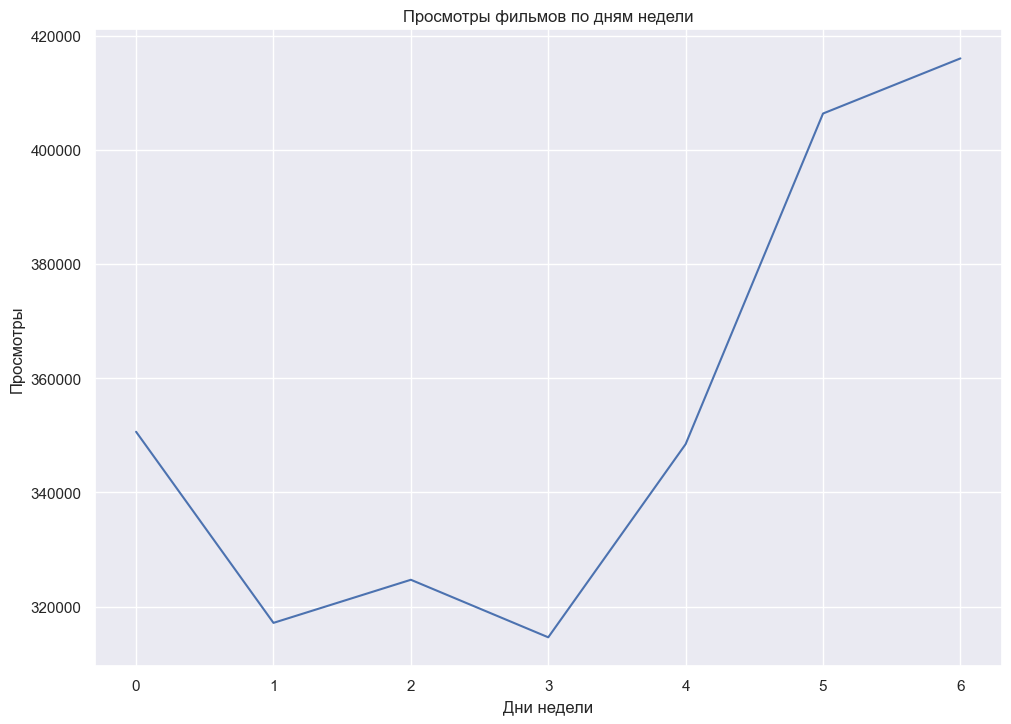

In [174]:
movie_views_by_day_of_week = logs_df.groupby('day_of_week')['movie_id'].count()

# Установите параметры графика
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

# Постройте график
sns.lineplot(data=movie_views_by_day_of_week)
plt.xlabel('Дни недели')
plt.ylabel('Просмотры')
plt.title('Просмотры фильмов по дням недели')
plt.show()

In [250]:
active_users = logs_df.groupby('user_id')['movie_id'].count()
active_users = pd.DataFrame(active_users).rename(columns={'movie_id':'movie_watch_cnt'})
active_users.reset_index(inplace=True)

print('Количество пользователей посмотревших больше 1000 фильмов:{}%'.format(round(((active_users[active_users['movie_watch_cnt'] >1000].shape[0])/len(active_users))*100,5)))
print('Количество пользователей посмотревших меньше или ровно 1000 фильмов:{}%'.format(round(((active_users[active_users['movie_watch_cnt'] <=1000].shape[0])/len(active_users))*100,5)))
print('Количество пользователей посмотревших больше 20 фильмов:{}%'.format(round(((active_users[active_users['movie_watch_cnt'] > 20].shape[0])/len(active_users))*100,2)))
print('Количество пользователей посмотревших один фильм:{}%'.format(round(((active_users[active_users['movie_watch_cnt'] == 1].shape[0])/len(active_users))*100,2)))
print('-'*80)
print(active_users['movie_watch_cnt'].describe())

Количество пользователей посмотревших больше 1000 фильмов:0.00289%
Количество пользователей посмотревших меньше или ровно 1000 фильмов:99.99711%
Количество пользователей посмотревших больше 20 фильмов:13.82%
Количество пользователей посмотревших один фильм:33.59%
--------------------------------------------------------------------------------
count    207377.000000
mean         11.948794
std          30.404118
min           1.000000
25%           1.000000
50%           3.000000
75%           9.000000
max        2350.000000
Name: movie_watch_cnt, dtype: float64


В данных пользователи с малой активностью, только 14% пользователей посмотрели больше 20 фильмов за 10 недель, а 33.5% пользователей посмотрели только один фильм. Такое распределение будет снижать значение точности предсказания т.к. недостаточно данных о предпочтении половины пользователей, так же подавляющая часть признаков становится не информативной. 33.5% пользователей будет рекомендоватся список ТОП-20 по просмотрам из обучающей выборки.